# Prediction of the flow

### Decision tree regression with the rainfall feature
Model trained on the historical values of the flow, the value of the recent rainfall and/or value from previous hour

### Importing necessary libraries

In [81]:
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import datetime as dt
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

### Loading the data sets

#### Rainfall data set

In [82]:
rainfall_set = pd.read_csv('../dataset/rainfall1.csv', parse_dates=['time'])
rainfall_set.head()

,time,rainfall
0,2014-10-24 00:00:00,0.0
1,2014-10-24 00:05:00,0.0
2,2014-10-24 00:10:00,0.0
3,2014-10-24 00:15:00,0.0
4,2014-10-24 00:20:00,0.0


In [83]:
rainfall_set.tail()

,time,rainfall
360143,2018-04-13 10:05:00,0.0
360144,2018-04-13 10:10:00,0.0
360145,2018-04-13 10:15:00,0.0
360146,2018-04-13 10:20:00,0.0
360147,2018-04-13 10:25:00,0.0


#### Flow data set

In [84]:
flow_set = pd.read_csv('../dataset/flow1.csv', parse_dates={'hour':['time']},index_col='hour')
dayfirst=True
flow_set = flow_set.resample('60T').mean()

In [85]:
flow_set = flow_set.reset_index()

In [86]:
flow_set['time'] = flow_set['hour']

In [87]:
flow_set.head()

,hour,flow,time
0,2015-06-01 14:00:00,113.754443,2015-06-01 14:00:00
1,2015-06-01 15:00:00,113.013333,2015-06-01 15:00:00
2,2015-06-01 16:00:00,114.081666,2015-06-01 16:00:00
3,2015-06-01 17:00:00,116.459167,2015-06-01 17:00:00
4,2015-06-01 18:00:00,123.825000,2015-06-01 18:00:00


### Leaving only a full hour as a feature

In [88]:
flow_set['hour'] = (flow_set['hour'].dt.hour)

In [89]:
flow_set.head()

,hour,flow,time
0,14,113.754443,2015-06-01 14:00:00
1,15,113.013333,2015-06-01 15:00:00
2,16,114.081666,2015-06-01 16:00:00
3,17,116.459167,2015-06-01 17:00:00
4,18,123.825000,2015-06-01 18:00:00


### Merging two data sets into one 
Merging is based on time column

In [90]:
flow_set = pd.merge(flow_set, rainfall_set, how='outer', on='time')

In [91]:
flow_set = flow_set.dropna()

In [92]:
flow_set.head()

,hour,flow,time,rainfall
0,14.0,113.754443,2015-06-01 14:00:00,0.0
1,15.0,113.013333,2015-06-01 15:00:00,0.0
2,16.0,114.081666,2015-06-01 16:00:00,0.0
3,17.0,116.459167,2015-06-01 17:00:00,0.0
4,18.0,123.825000,2015-06-01 18:00:00,0.0


### Adding the feature of previous hour's flow value

In [94]:
flow_set['previous-hour'] = flow_set['flow'].shift(1)

In [97]:
flow_set = flow_set.dropna()
flow_set.head()

,hour,flow,time,rainfall,previous-hour
1,15.0,113.013333,2015-06-01 15:00:00,0.0,113.754443
2,16.0,114.081666,2015-06-01 16:00:00,0.0,113.013333
3,17.0,116.459167,2015-06-01 17:00:00,0.0,114.081666
4,18.0,123.825000,2015-06-01 18:00:00,0.0,116.459167
5,19.0,128.884998,2015-06-01 19:00:00,0.0,123.825000


### General plot of rainfall in time

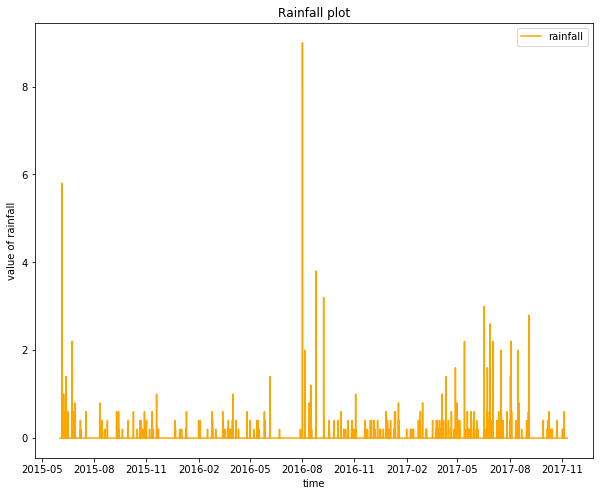

In [114]:
plt.figure(figsize=(10, 8))
plt.plot(flow_set['time'], flow_set['rainfall'], color="orange", label="rainfall")
plt.xlabel("time")
plt.ylabel("value of rainfall")
plt.title("Rainfall plot")
plt.legend()
plt.show()